In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


Подключение библиотек и скриптов

In [33]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math as math
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
matplotlib.rcParams.update({'font.size': 14})

In [36]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()


Пути к директориям и файлам

In [37]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

Загузка данных

In [38]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [39]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


**1. EDA**

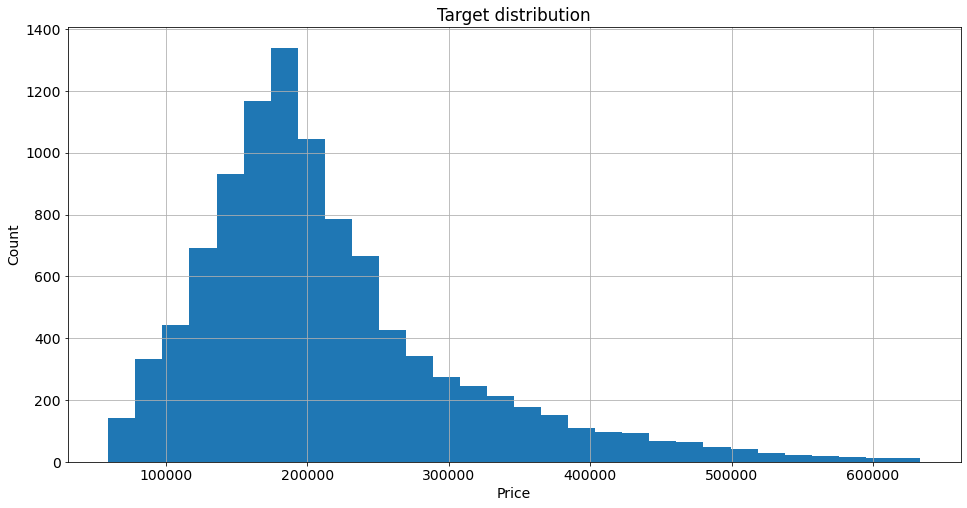

In [40]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()


In [41]:
class DataPreprocessing:
    
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        #self.kitchen_square_quantile = None

    # Rooms    
    def fix_rooms(self, df):

        Median_square = df.groupby('Rooms')[['Square', 'AverageRoomSquare']].median()    

        print(Median_square)

        for idx, row in df.iterrows():

            if (row.Rooms > 0) and (row.AverageRoomSquare >= 10):
                continue

            print(f"Было Rooms: {row.Rooms}, Square {row.Square}")

            if row.Square < 50:
                df.loc[idx, 'Rooms'] = 1
                print(f"Стало Rooms: 1, Square {row.Square}")           
                continue

            rooms_count = 0
            for idx1, row1 in Median_square.iterrows():
                if (idx1 == 0) or (row1.AverageRoomSquare < 10):
                    continue
                if row.Square >= row1.Square and rooms_count < idx1:
                    rooms_count = idx1

            if rooms_count > 0:
                df.loc[idx, 'Rooms'] = rooms_count
                print(f"Стало Rooms: {rooms_count}, Square {row.Square}")
            else:
                df.loc[idx, 'Rooms'] = round(row.Square / 23)
                print(f"Стало Rooms: {round(row.Square / 23)}, Square {row.Square}")

        df['AverageRoomSquare'] = df.Square / df.Rooms    
        
    # KitchenSquare
    def fix_square(self, df):
        
        Median_square = df.groupby('Rooms')[['Square', 'LifeSquare', 'KitchenSquare']].median()
        for idx, row in df.iterrows():
            if (row.KitchenSquare > 100 or row.KitchenSquare > row.Square / 2 or row.KitchenSquare < 4):
                df.loc[idx, 'KitchenSquare'] = Median_square.loc[row.Rooms].KitchenSquare

        df['OtherSquare'] = df.Square - df.LifeSquare - df.KitchenSquare            

        #Если LifeSquare слишком маленькая или OtherSquare < 0 
        for idx, row in df.iterrows():
            if (row.OtherSquare < 0) or ((row.LifeSquare / row.Rooms) < 10):
                df.loc[idx, 'LifeSquare'] = row.Square - row.KitchenSquare

        df['OtherSquare'] = df.Square - df.LifeSquare - df.KitchenSquare 
        
    # HouseFloor, Floor    
    def fix_Floor(self, df):

        current_year = datetime.now().year

        index_to_do = df[(df['HouseFloor'] > 30) & (df['HouseYear'] < 2000) & (df['Floor'] <= 10)].index
        for idx in index_to_do:
            df.loc[idx, 'HouseFloor'] = df.loc[idx, 'Floor']

        Median_year = df.groupby('HouseFloor')[['HouseYear']].median()
        index_to_do = df[(df['HouseFloor'] > 30) & (df['HouseYear'] < 2000) & (df['Floor'] > 10)].index
        for idx in index_to_do:
            df.loc[idx, 'HouseYear'] = Median_year.loc[df.loc[idx, 'HouseFloor'], 'HouseYear']

            index_to_do = df[(df['HouseFloor'] > 5) & (df['HouseYear'] < 1920)].index
        for idx in index_to_do:
            df.loc[idx, 'HouseYear'] = Median_year.loc[df.loc[idx, 'HouseFloor'], 'HouseYear']

        index_to_do = df[df['HouseYear'] > current_year].index
        for idx in index_to_do:
            df.loc[idx, 'HouseYear'] = Median_year.loc[df.loc[idx, 'HouseFloor'], 'HouseYear']

        index_to_do = df[df['HouseFloor'] < df['Floor']].index
        for idx in index_to_do:
            df.loc[idx, 'HouseFloor'] = df.loc[idx, 'Floor']   

    # Заполнение нулями        
    def fill_NAN(self, df):
        df['OtherSquare'].fillna(0, inplace = True)

    # Заполним LifeSquare = Square - KitchenSquare - OtherSquare
        index_to_do = df.loc[df['LifeSquare'].isnull()].index
        for idx in index_to_do:
            df.loc[idx, 'LifeSquare'] = df.loc[idx, 'Square'] - df.loc[idx, 'KitchenSquare'] - df.loc[idx, 'OtherSquare']

    #Предположим, что Healthcare_1 зависит от района попробуем заполнить пропуски медианными значениями
    #Если медианное по району = NAN то возьмем общую медиану
        Median_Healthcare_1_District = df.groupby('DistrictId')[['Healthcare_1']].median()
        Median_Healthcare_1 = df['Healthcare_1'].median()

        index_to_do = df[df['Healthcare_1'].isnull()].index
        for idx in index_to_do:
            if math.isnan(Median_Healthcare_1_District.loc[df.loc[idx, 'DistrictId'], 'Healthcare_1']):
                df.loc[idx, 'Healthcare_1'] = Median_Healthcare_1
            else:    
                df.loc[idx, 'Healthcare_1'] = Median_Healthcare_1_District.loc[df.loc[idx, 'DistrictId'], 'Healthcare_1']
    
    def add_control_features(self, X):
        # дополнительные признаки для анализа выбросов и дальнейшего использования
        X['OtherSquare'] = X.Square - X.LifeSquare - X.KitchenSquare
        X['AverageRoomSquare'] = X.Square / X.Rooms
        
        return X
    
    
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()

        # дополнительные признаки для анализа выбросов
        X['Price_metre'] = round(X.Price / X.Square, 2)        
        
        #Посмотрим строки, где совсем все плохо и удалим их из набора: 
#         ind_to_drop = X[((X['AverageRoomSquare'] < 10) & (X['OtherSquare'] < 0)) | (X['Square'] < 10) ].index #| (X['Price_metre'] < 500)
#         X = X.drop(ind_to_drop, axis = 0)
#         X = X.drop('Price_metre', axis = 1)
        
        #Если выбросить откровенно плохие строки, то модель работает хуже
        
        return X
    
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['AverageRoomSquare'] < 10), 'Rooms_outlier'] = 1
        
        self.fix_rooms(X)
        self.fix_square(X)
        
        # HouseYear
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] > 30) & (X['HouseYear'] < 2000), 'HouseFloor_outlier'] = 1
        X.loc[(X['HouseFloor'] > 5) & (X['HouseYear'] < 1920), 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        
        self.fix_Floor(X) #вообще никак не влияет на результат 
        
        # Заполнение нулями LifeSquare, Healthcare1
        self.fill_NAN(X)
        
        
        # Приведение типов
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)
        
        
        X.fillna(self.medians, inplace=True)
        
        return X


In [42]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
                
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()        
        
        
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')  
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)        
        
        return X
    
    
    def floor_to_cat(self, X):
            bins = [0, 3, 5, 9, 15, self.floor_max]
            X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

            X['floor_cat'].fillna(-1, inplace=True) 
            return X
     
    
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


In [43]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()

train_df = preprocessor.add_control_features(train_df)
test_df = preprocessor.add_control_features(test_df)

train_df = preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)
train_df.shape, test_df.shape


           Square  AverageRoomSquare
Rooms                               
0.0     65.487474                inf
1.0     40.406590          40.406590
2.0     55.841812          27.920906
3.0     77.413643          25.804548
4.0     98.668054          24.667013
5.0    116.084861          23.216972
6.0     59.414334           9.902389
10.0    59.964120           5.996412
19.0    42.006046           2.210845
Было Rooms: 1.0, Square 2.954308616913197
Стало Rooms: 1, Square 2.954308616913197
Было Rooms: 3.0, Square 4.390330860271007
Стало Rooms: 1, Square 4.390330860271007
Было Rooms: 1.0, Square 5.129221611525365
Стало Rooms: 1, Square 5.129221611525365
Было Rooms: 10.0, Square 59.05697501990758
Стало Rooms: 2.0, Square 59.05697501990758
Было Rooms: 0.0, Square 38.6971170089138
Стало Rooms: 1, Square 38.6971170089138
Было Rooms: 10.0, Square 60.87126567734032
Стало Rooms: 2.0, Square 60.87126567734032
Было Rooms: 5.0, Square 42.00329332353966
Стало Rooms: 1, Square 42.00329332353966
Было Roo

((10000, 25), (5000, 23))

In [44]:
features_gen = FeatureGenetator()
features_gen.fit(train_df.drop(columns='Price'), train_df['Price'])

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)
train_df.shape, test_df.shape

((10000, 32), (5000, 30))

In [45]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

In [46]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Price_metre,Rooms_outlier,HouseFloor_outlier,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.886900,56.315775,40.119571,7.43630,8.526700,13.406100,1984.914950,0.118858,0.990300,0.972500,...,3988.383741,0.002800,0.183700,242.306600,0.0,0.506900,1.963400,2.814000,211499.890992,197609.833086
std,0.811526,21.058732,20.407017,2.31648,5.241148,5.883421,18.322862,0.119025,0.098015,0.163543,...,3755.437237,0.052844,0.387259,268.992652,0.0,0.499977,1.256829,1.166851,76619.702002,28463.621434
min,1.000000,1.136859,-4.863141,4.00000,1.000000,1.000000,1917.000000,0.000000,0.000000,0.000000,...,208.290000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,82342.775873,159052.470665
25%,1.000000,41.774881,26.841192,6.00000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,2918.527500,0.000000,0.000000,55.000000,0.0,0.000000,1.000000,2.000000,165071.825722,181147.535427
50%,2.000000,52.513310,35.421219,7.00000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,3910.055000,0.000000,0.000000,104.000000,0.0,1.000000,2.000000,2.000000,195641.106322,188036.089837
75%,2.000000,65.900625,48.699438,9.00000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,4692.372500,0.000000,0.000000,511.000000,0.0,1.000000,3.000000,4.000000,241068.903045,210197.972901
max,5.000000,641.065193,631.065193,43.00000,42.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,...,230463.540000,1.000000,1.000000,851.000000,0.0,1.000000,4.000000,5.000000,624156.003381,509182.957515


In [47]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'OtherSquare',
 'AverageRoomSquare',
 'Price_metre',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'floor_cat',
 'year_cat',
 'MedPriceByDistrict',
 'MedPriceByFloorYear']

In [48]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 
                 'Helthcare_2', 'Shops_1', 'Shops_2']  #'Healthcare_1'

new_feature_names = ['Rooms_outlier'] 
#, 'OtherSquare', 'Rooms_outlier', 'HouseFloor_outlier']'DistrictSize',  'MedPriceByFloorYear''IsDistrictLarge'

# new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
#                      'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

Разбиение на train и test

In [49]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [50]:
test_df = test_df[feature_names + new_feature_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

Построение модели

In [51]:
# parameters = {
#     'n_estimators': [100, 120, 150, 200, 250],
#     'max_features': np.arange(5, 9),
#     'max_depth': np.arange(5, 12),
# }

# clf = GridSearchCV(
#     estimator=RandomForestRegressor(),
#     param_grid=parameters,
#     scoring='r2',
#     cv=5,
# )

In [52]:
# clf.fit(X_train, y_train)

In [53]:
# cv_results = pd.DataFrame(clf.cv_results_)
# cv_results.columns

In [54]:
# param_columns = [
#     column
#     for column in cv_results.columns
#     if column.startswith('param_')
# ]

# score_columns = ['mean_test_score']

# cv_results = (cv_results[param_columns + score_columns]
#               .sort_values(by=score_columns, ascending=False))

# cv_results.head(10)

In [55]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# rf_model.fit(X_train, y_train)
# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_test)

# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_train_preds = lr.predict(X_train)
# y_test_preds = lr.predict(X_test)

rfr = RandomForestRegressor(max_depth = 11, n_estimators = 200, max_features = 8, random_state = 42)
rfr.fit(X_train, y_train.values) #rfr.fit(X, y.values)
y_train_preds = rfr.predict(X_train)
y_test_preds = rfr.predict(X_test)

Train R2:	0.875
Test R2:	0.746


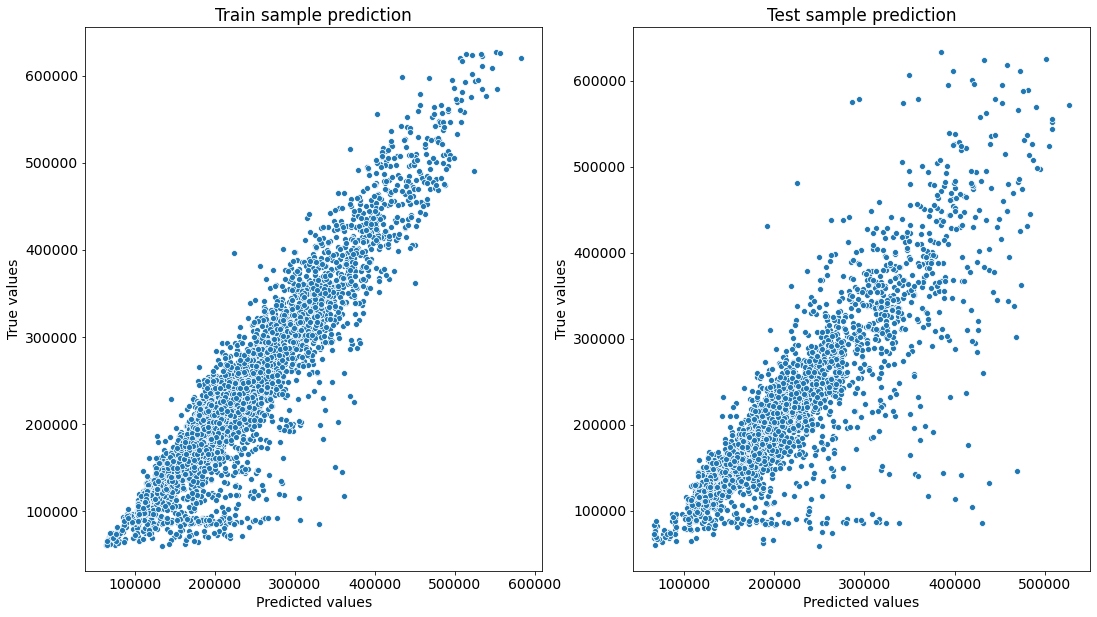

In [56]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Кросс-валидация

In [57]:
cv_score = cross_val_score(rfr, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.74140395, 0.71903162, 0.74647813])

Важность признаков

In [58]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfr.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.308411
1,Rooms,0.136047
12,Social_2,0.098388
11,Social_1,0.089253
3,LifeSquare,0.067502
13,Social_3,0.066830
0,DistrictId,0.048651
8,Ecology_1,0.037911
4,KitchenSquare,0.037247
7,HouseYear,0.030176


Прогнозирование на тестовом датасете

In [59]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [60]:
predictions = rfr.predict(test_df)
predictions

array([160543.92026424, 123231.85280164, 148423.3841755 , ...,
       150623.78796441, 186846.70755738, 272431.582208  ])

In [61]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160543.920264
1,5925,123231.852802
2,960,148423.384175
3,3848,127847.597298
4,746,223373.123998


In [62]:
submit.to_csv('rf_submit.csv', index=False)